# Import main libraries

In [254]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [255]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [256]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Loading data

In [257]:
builder = tfds.builder("tf_flowers")
builder.download_and_prepare()
print(builder.info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [258]:
(raw_train, raw_validation, raw_test) = builder.as_dataset(split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], as_supervised=True)

In [259]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


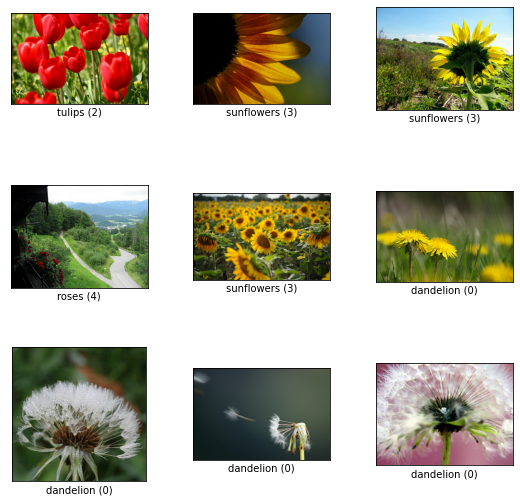

In [260]:
train_data = builder.as_dataset(split="train")
fig = tfds.show_examples(train_data, builder.info)

Show the first two images and labels from the training set:

In [261]:
IMG_SIZE = 100 # All images will be resized to 100x100

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = image / 255.0
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [262]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [263]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# First model: DNN

In [264]:
num_classes = builder.info.features['label'].num_classes # 5 CLASSES

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B

# Write your neural network here!

In [265]:
# Source: 02_cnn_template.ipynb

# Our input feature map is 100x100x3: 100x100 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
# Convolution2D == Conv2D
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# TODO 2. Add a dropout layer with a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with 5 nodes and sigmoid activation
output = layers.Dense(num_classes, activation='softmax')(x)

In [266]:
# Configure and compile the model
model = Model(img_input, output)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [267]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_291 (Conv2D)          (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_292 (Conv2D)          (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_293 (Conv2D)          (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 10, 10, 64)        0   

## Fit

In [268]:
#fit the model
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=validation_batches,
                    workers=-1,
                    use_multiprocessing=True)

Epoch 1/30
23/23 [==============================] - 7s 209ms/step - loss: 1.7220 - acc: 0.2908 - val_loss: 1.2440 - val_acc: 0.5095
Epoch 2/30
23/23 [==============================] - 4s 136ms/step - loss: 1.2706 - acc: 0.4702 - val_loss: 1.2188 - val_acc: 0.4850
Epoch 3/30
23/23 [==============================] - 4s 133ms/step - loss: 1.1632 - acc: 0.5216 - val_loss: 1.2738 - val_acc: 0.4659
Epoch 4/30
23/23 [==============================] - 4s 133ms/step - loss: 1.1098 - acc: 0.5671 - val_loss: 1.0106 - val_acc: 0.6158
Epoch 5/30
23/23 [==============================] - 4s 132ms/step - loss: 1.0116 - acc: 0.6115 - val_loss: 1.1545 - val_acc: 0.5313
Epoch 6/30
23/23 [==============================] - 4s 133ms/step - loss: 0.9592 - acc: 0.6157 - val_loss: 0.9089 - val_acc: 0.6431
Epoch 7/30
23/23 [==============================] - 4s 131ms/step - loss: 0.8589 - acc: 0.6708 - val_loss: 0.9571 - val_acc: 0.6458
Epoch 8/30
23/23 [==============================] - 4s 131ms/step - loss: 0.

## Performance

Text(0.5, 1.0, 'Training and validation loss')

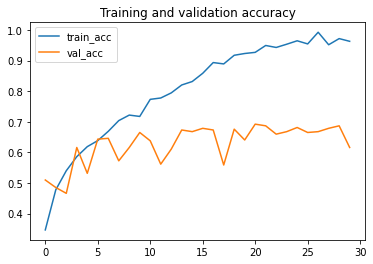

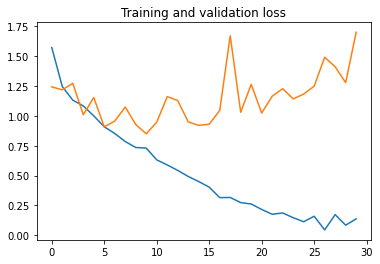

In [269]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [270]:
model.evaluate(
    test_batches,
    verbose=1,
    max_queue_size=10,
    workers=-1,
    use_multiprocessing=True)

3/3 [==============================] - 1s 218ms/step - loss: 1.7411 - acc: 0.5640


[1.7410706281661987, 0.5640326738357544]

# **[TODO] IMPROVE THE MODEL BY USING INCEPTION V3**

## Load Inception V3

In [271]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-02-19 14:47:51--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 64.233.184.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  59.4MB/s    in 1.4s    

2021-02-19 14:47:52 (59.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [272]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [273]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [274]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 4, 768)


## Model compilation

In [275]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [276]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_294 (Conv2D)             (None, 49, 49, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 49, 49, 32)   96          conv2d_294[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 49, 49, 32)   0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

## Load data

In [277]:
#Download the files
!wget --no-check-certificate \
   http://download.tensorflow.org/example_images/flower_photos.tgz -O \
   flower_photos.tgz

--2021-02-19 14:47:55--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.5.128, 2a00:1450:400c:c1b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.5.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  83.8MB/s    in 2.6s    

2021-02-19 14:47:58 (83.8 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



### Data split

In [278]:
# Import libraries
import os
import tarfile
import shutil
# import zipfile
# import random

In [279]:
#Remove and make
shutil.rmtree("flower", ignore_errors=True)
# os.makedirs('/tmp/flower/val/', exist_ok=True)

In [280]:
# Explode
local_zip = 'flower_photos.tgz'
tar = tarfile.open(local_zip, "r:gz")
tar.extractall('flower')
tar.close()

In [281]:
# os.rename('/tmp/flower/flower_photos', '/tmp/flower/train')

In [282]:
# # Split the pictures into `train` ant `test`
# # https://stackoverflow.com/a/59952784/3780957

# flower_types = ['roses', 'daisy', 'sunflowers', 'tulips', 'dandelion']
# folders = ['validation', 'train']

# for ft in flower_types:
#   for fd in folders:

#     source = os.path.join('/tmp/flower/train', ft)
#     dest = os.path.join('/tmp/flower/', fd, ft)

#     files = os.listdir(source)
#     no_of_files = len(files) // 10
#     os.makedirs(dest)

#     for file_name in random.sample(files, no_of_files):
#         shutil.move(os.path.join(source, file_name), dest)

In [283]:
# https://pypi.org/project/split-folders/
!pip install split-folders
import splitfolders

splitfolders.ratio('flower/flower_photos', output="flower", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 3670 files [00:01, 3138.14 files/s]


## ImageDataGenerator

In [284]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define our example directories and files
base_dir = 'flower'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# https://keras.io/api/preprocessing/image/#flowfromdataframe-method
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="binary",
    batch_size=20)

# Note that the test data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)
# Flow test images in batches of 20 using val_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="binary",
    batch_size=20)

# Note that the test data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)
# Flow test images in batches of 20 using val_datagen generator
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="binary",
    batch_size=20)

Found 2934 images belonging to 5 classes.
Found 364 images belonging to 5 classes.
Found 372 images belonging to 5 classes.


## Fit

In [285]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    workers=-1,
                    use_multiprocessing=True)

Epoch 1/30
147/147 [==============================] - 24s 140ms/step - loss: 3.7916 - acc: 0.5287 - val_loss: 0.8760 - val_acc: 0.6978
Epoch 2/30
147/147 [==============================] - 20s 133ms/step - loss: 0.8838 - acc: 0.7095 - val_loss: 0.6872 - val_acc: 0.7665
Epoch 3/30
147/147 [==============================] - 19s 130ms/step - loss: 0.7417 - acc: 0.7555 - val_loss: 0.6524 - val_acc: 0.8022
Epoch 4/30
147/147 [==============================] - 19s 130ms/step - loss: 0.6527 - acc: 0.7839 - val_loss: 0.7433 - val_acc: 0.7995
Epoch 5/30
147/147 [==============================] - 19s 132ms/step - loss: 0.6725 - acc: 0.7777 - val_loss: 0.7078 - val_acc: 0.7775
Epoch 6/30
147/147 [==============================] - 19s 130ms/step - loss: 0.6026 - acc: 0.8049 - val_loss: 0.7051 - val_acc: 0.8104
Epoch 7/30
147/147 [==============================] - 19s 131ms/step - loss: 0.5592 - acc: 0.8119 - val_loss: 0.6877 - val_acc: 0.8242
Epoch 8/30
147/147 [==============================] - 1

## Performance

Text(0.5, 1.0, 'Training and validation loss')

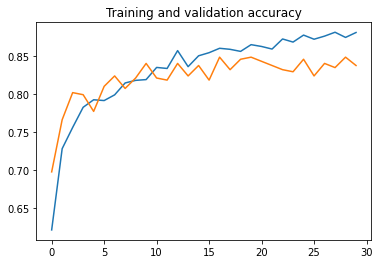

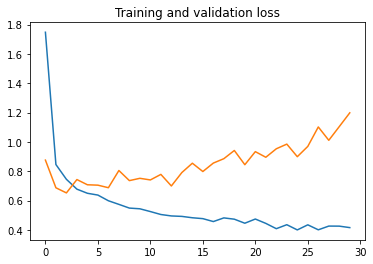

In [286]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [287]:
model.evaluate(
    test_generator,
    verbose=1,
    max_queue_size=10,
    workers=-1,
    use_multiprocessing=True)

19/19 [==============================] - 1s 72ms/step - loss: 0.9533 - acc: 0.8199


[0.9533065557479858, 0.8198924660682678]

# Unfreeze layers of the Inception V3 model

In [288]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

## Fit

In [289]:
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    workers=-1,
                    use_multiprocessing=True)

Epoch 1/30
147/147 [==============================] - 25s 145ms/step - loss: 0.7593 - acc: 0.7858 - val_loss: 0.8954 - val_acc: 0.8297
Epoch 2/30
147/147 [==============================] - 20s 135ms/step - loss: 0.6972 - acc: 0.7969 - val_loss: 0.9231 - val_acc: 0.8269
Epoch 3/30
147/147 [==============================] - 20s 135ms/step - loss: 0.6064 - acc: 0.8068 - val_loss: 0.9227 - val_acc: 0.8297
Epoch 4/30
147/147 [==============================] - 20s 134ms/step - loss: 0.5983 - acc: 0.8069 - val_loss: 0.9170 - val_acc: 0.8242
Epoch 5/30
147/147 [==============================] - 20s 133ms/step - loss: 0.5736 - acc: 0.8182 - val_loss: 0.9043 - val_acc: 0.8269
Epoch 6/30
147/147 [==============================] - 20s 133ms/step - loss: 0.5725 - acc: 0.8077 - val_loss: 0.9014 - val_acc: 0.8242
Epoch 7/30
147/147 [==============================] - 20s 134ms/step - loss: 0.6616 - acc: 0.8013 - val_loss: 0.8864 - val_acc: 0.8269
Epoch 8/30
147/147 [==============================] - 1

## Performance

Text(0.5, 1.0, 'Training and validation loss')

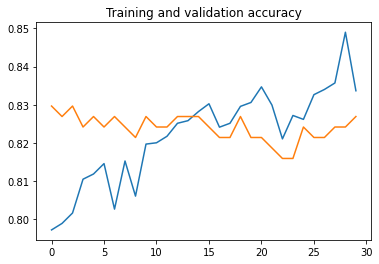

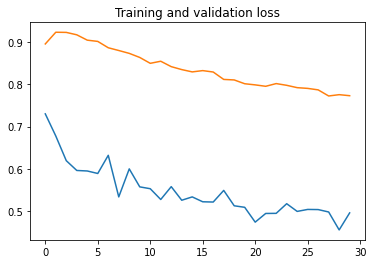

In [290]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [291]:
model.evaluate(
    test_generator,
    verbose=1,
    max_queue_size=10,
    workers=-1,
    use_multiprocessing=True)

19/19 [==============================] - 1s 70ms/step - loss: 0.5980 - acc: 0.8414


[0.5980048775672913, 0.8413978219032288]

In [292]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)